In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math

# 重建评估

In [3]:
def sr_mse(src_img, dst_img):

    X = np.float32(src_img)
    Y = np.float32(dst_img)
    mse = np.mean(np.square(X-Y))
    return mse

def sr_pnsr(src_img, dst_img):

    mse = sr_mse(src_img, dst_img)
    range = 255
    pnsr = 10 * np.log10(range**2/mse)
    return pnsr

def sr_ssim(src_img, dst_img):
    X = np.float32(src_img)
    Y = np.float32(dst_img)
    mu1 = X.mean()
    mu2 = Y.mean()
    sigma1 = np.sqrt(((X - mu1) ** 2).mean())
    sigma2 = np.sqrt(((Y - mu2) ** 2).mean())
    sigma12 = ((X - mu1) * (Y - mu2)).mean()
    k1, k2, L = 0.01, 0.03, 255
    C1 = (k1*L) ** 2
    C2 = (k2*L) ** 2
    C3 = C2/2
    l12 = (2*mu1*mu2 + C1)/(mu1 ** 2 + mu2 ** 2 + C1)
    c12 = (2*sigma1*sigma2 + C2)/(sigma1 ** 2 + sigma2 ** 2 + C2)
    s12 = (sigma12 + C3)/(sigma1*sigma2 + C3)
    ssim = l12 * c12 * s12
    return ssim


def print_sr_value(src_img, dst_img):
    print("mse:{0}".format(sr_mse(src_img,dst_img)))
    print("pnsr:{0}".format(sr_pnsr(src_img, dst_img)))
    print("ssim:{0}".format(sr_ssim(src_img, dst_img)))

In [4]:
def get_lr_img(src_img, scale):
    srcH, srcW, channel = src_img.shape
    dstH, dstW = srcH//scale, srcW//scale
    dst_img = np.zeros((dstH, dstW, channel), dtype=np.uint8)
    for k in range(channel):
        for i in range(dstH):
            for j in range(dstW):
                dst_img[i,j,k] = src_img[i*scale, j*scale, k]
    return dst_img

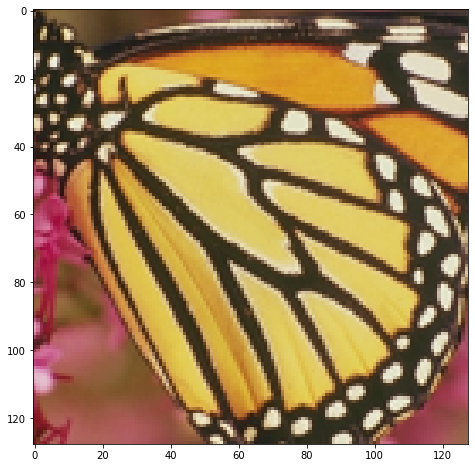

In [5]:
src = cv2.imread("bufy_hr.png")
src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
h, w = src.shape[0:2]

#lr = get_lr_img(src, 2)
lr = cv2.imread("bufy_lr.png")
lr = cv2.cvtColor(lr, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12,8))
plt.imshow(lr)


# 最邻近插值

In [6]:
def nearest_interpolation(src_img, dstH, dstW):
    srcH, srcW, channel = src_img.shape
    dst_img = np.zeros((dstH, dstW, channel), dtype=np.uint8)
    for k in range(channel):
        for i in range(dstH):
            for j in range(dstW):
                x = min(round(i * (srcH/dstH)), srcH-1)
                y = min(round(j * (srcH/dstH)), srcW-1)
                dst_img[i, j, k] = src_img[x, y, k]
    return dst_img


mse:573.9417114257812
pnsr:20.542125724621705
ssim:0.9412883309229111


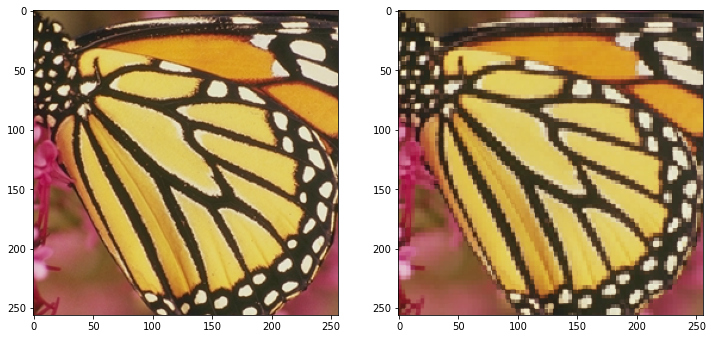

In [7]:
hr = nearest_interpolation(lr, h, w)
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(src)

plt.subplot(1,2,2)
plt.imshow(hr)

print_sr_value(src, hr)

# 双三次插值


In [8]:
def S(a, x):

    x = abs(x)
    if x <= 1:
        res = (a+2)*x**3 - (a+3)*x**2 + 1
    elif 1 < x and x < 2:
        res = a*x**3 - 5*a*x**2 + 8*a*x - 4*a
    else:
        res = 0
    return res

def bicubic_interpolation(src_img, dstH, dstW, a):
    srcH, srcW, channel = src_img.shape
    src_img = np.pad(src_img, ((2, 2), (2, 2), (0, 0)), 'edge')
    dst_img = np.zeros((dstH, dstW, channel), dtype=np.uint8)
    for k in range(channel):
        for i in range(dstH):
            for j in range(dstW):
                x = i * (srcH/dstH) + 2  # Padding尺寸为2
                y = j * (srcW/dstW) + 2
                p = math.floor(x)        # 整数部分
                q = math.floor(y)
                u = x - p                # 小数部分
                v = y - q
                A = np.array([S(a,1+u), S(a,u), S(a,1-u), S(a,2-u)])
                B = np.array([[src_img[p-1,q-1,k], src_img[p-1,q,k], src_img[p-1,q+1,k], src_img[p-1,q+2,k]],
                              [src_img[p,  q-1,k], src_img[p,  q,k], src_img[p,  q+1,k], src_img[p  ,q+2,k]],
                              [src_img[p+1,q-1,k], src_img[p+1,q,k], src_img[p+1,q+1,k], src_img[p+1,q+2,k]],
                              [src_img[p+2,q-1,k], src_img[p+2,q,k], src_img[p+2,q+1,k], src_img[p+2,q+2,k]]])
                C = np.array([[S(a,1+v)], [S(a,v)], [S(a,1-v)], [S(a,2-v)]])
                
                dst_img[i,j,k] = np.clip(A@B@C, 0, 255)

    return dst_img

mse:276.0227966308594
pnsr:23.72135409084796
ssim:0.9717866753814803


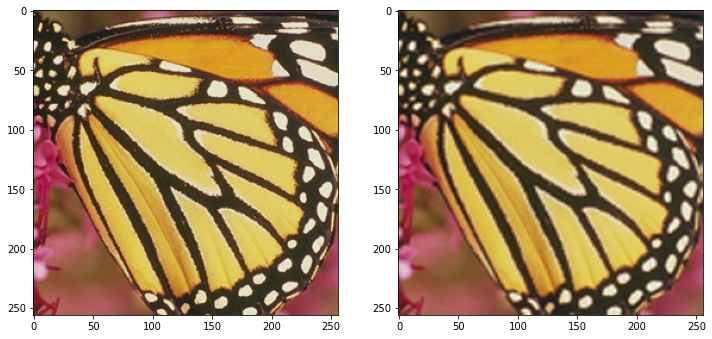

In [9]:
a = -0.75

hr = bicubic_interpolation(lr, h, w, a)
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(src)


plt.subplot(1,2,2)
plt.imshow(hr)

print_sr_value(src, hr)

# 高通滤波和低通滤波

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


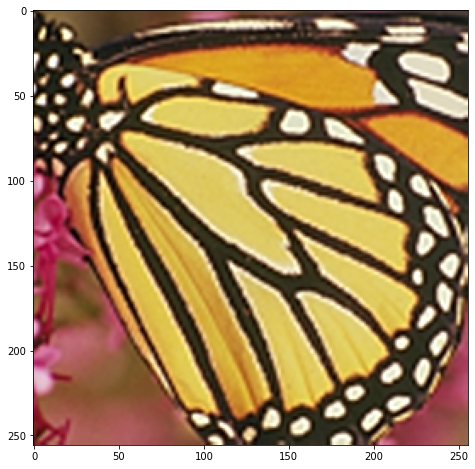

In [21]:
plt.figure(figsize=(12,8))
hd = cv2.Laplacian(hr,cv2.CV_16S,7)
ld = cv2.GaussianBlur(hd,(5,5),0)
hr2 = hr - ld
plt.imshow(hr2)

mse:171.2629852294922
pnsr:25.794168510700576
ssim:0.9836573440779306


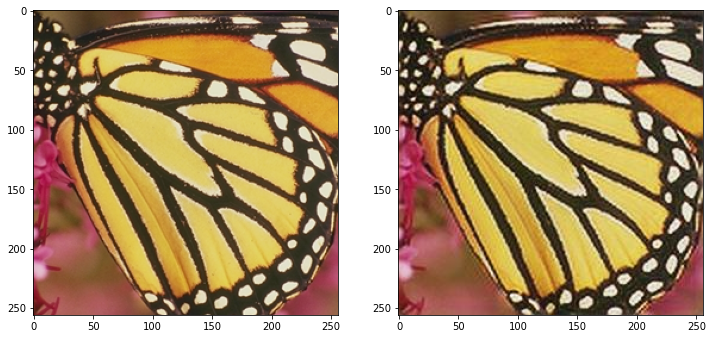

In [11]:
org = cv2.imread("bufy_hr.png")
org = cv2.cvtColor(org, cv2.COLOR_BGR2RGB)

SR = cv2.imread("srresnet.jpg")
SR = cv2.cvtColor(SR, cv2.COLOR_BGR2RGB)


plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(org)


plt.subplot(1,2,2)
plt.imshow(SR)

print_sr_value(org, SR)